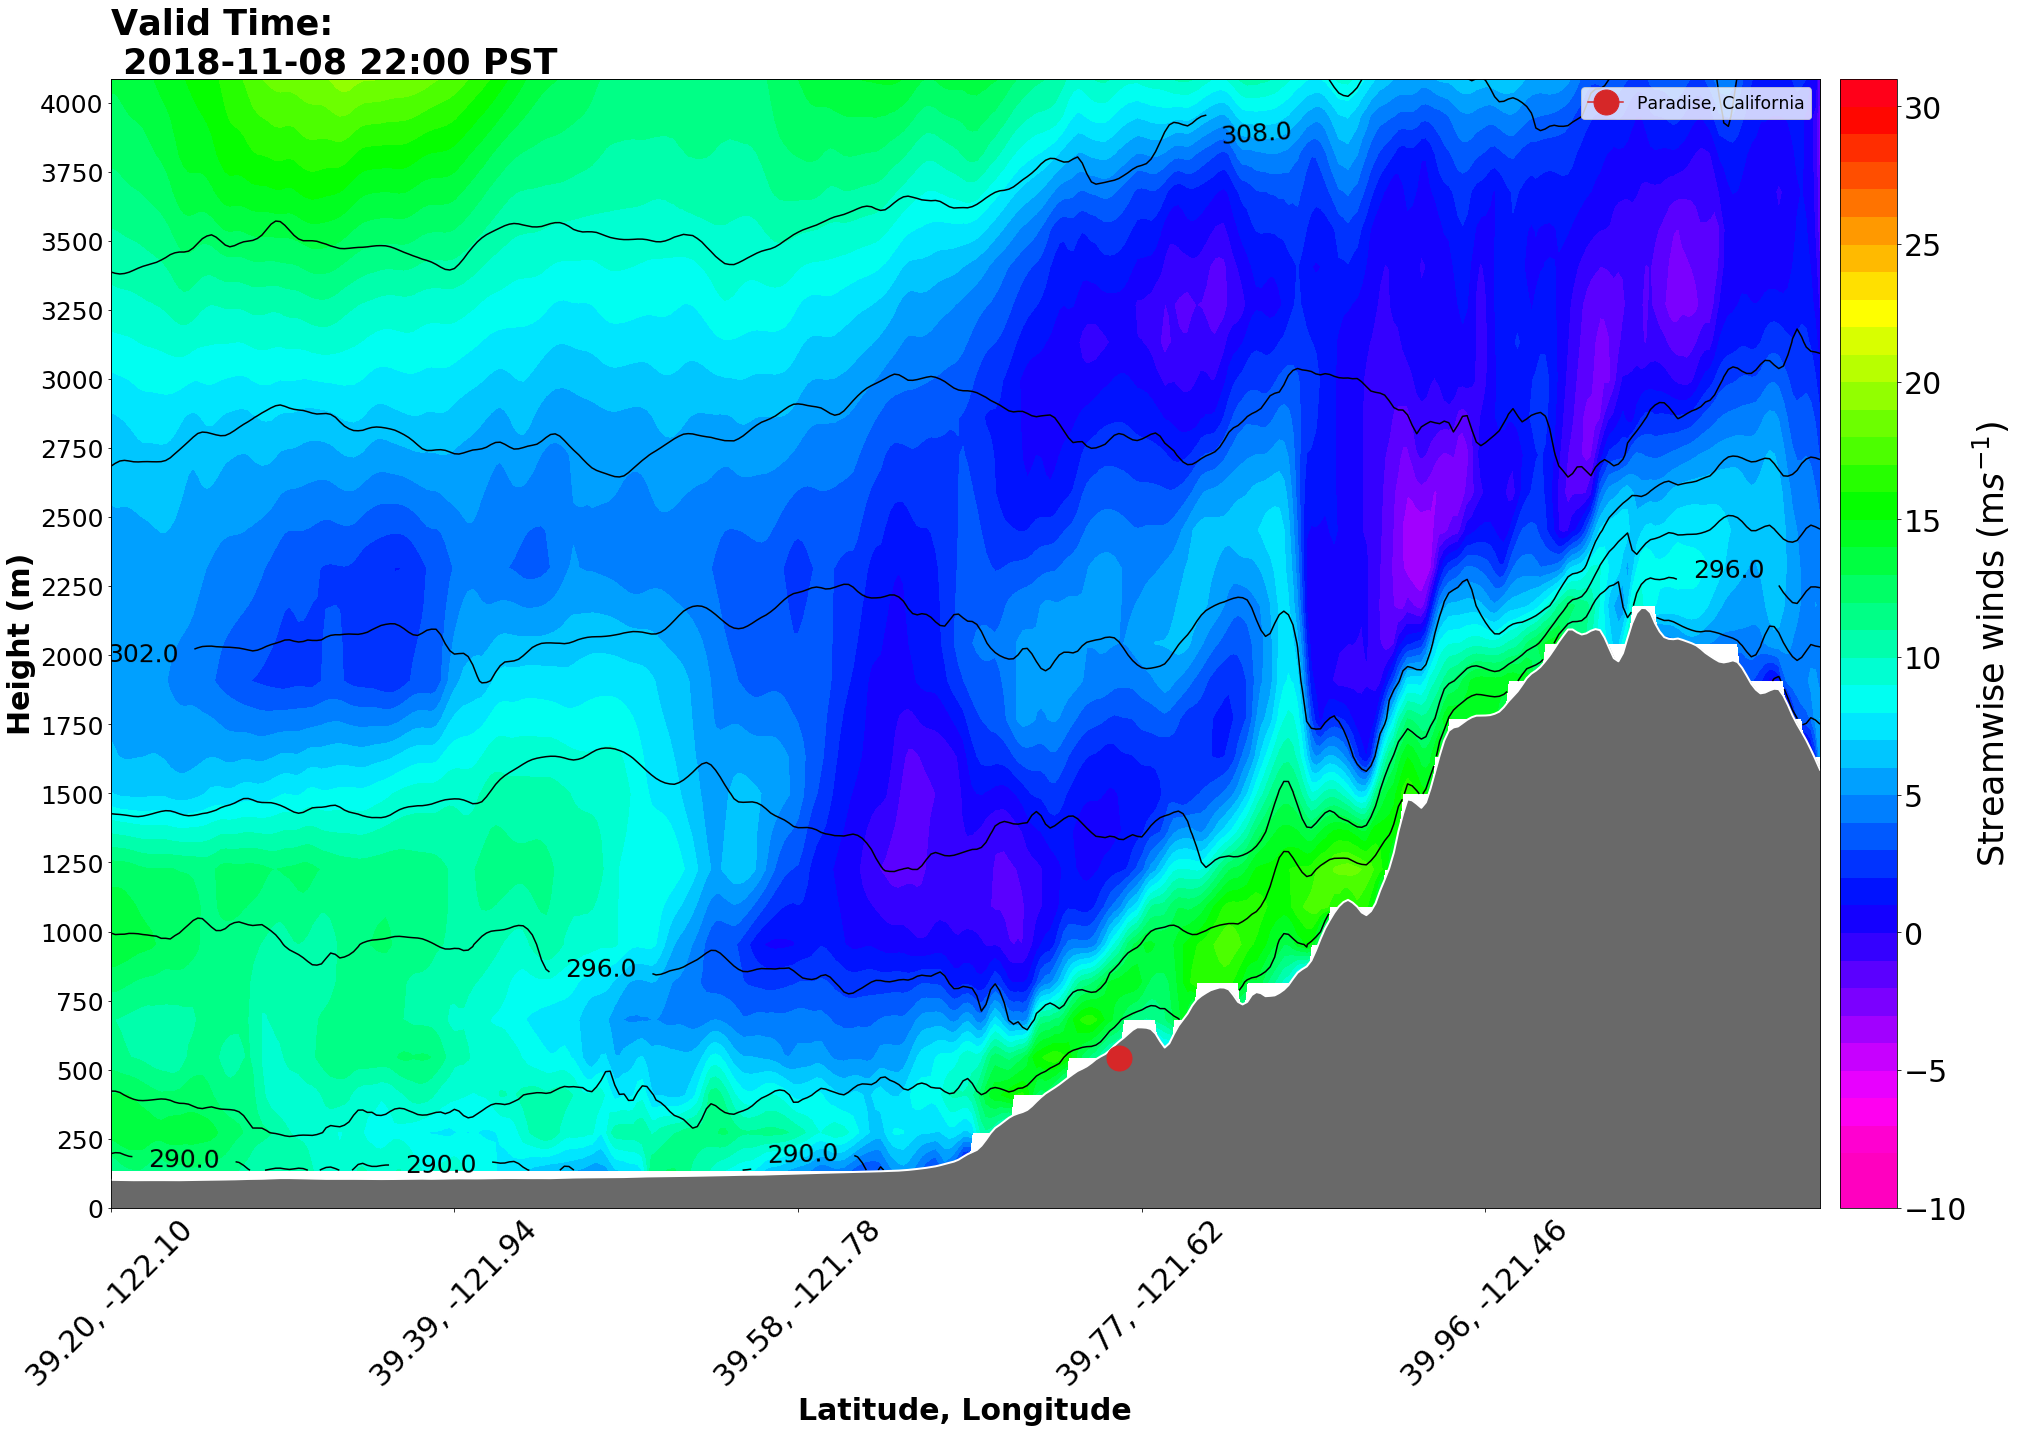

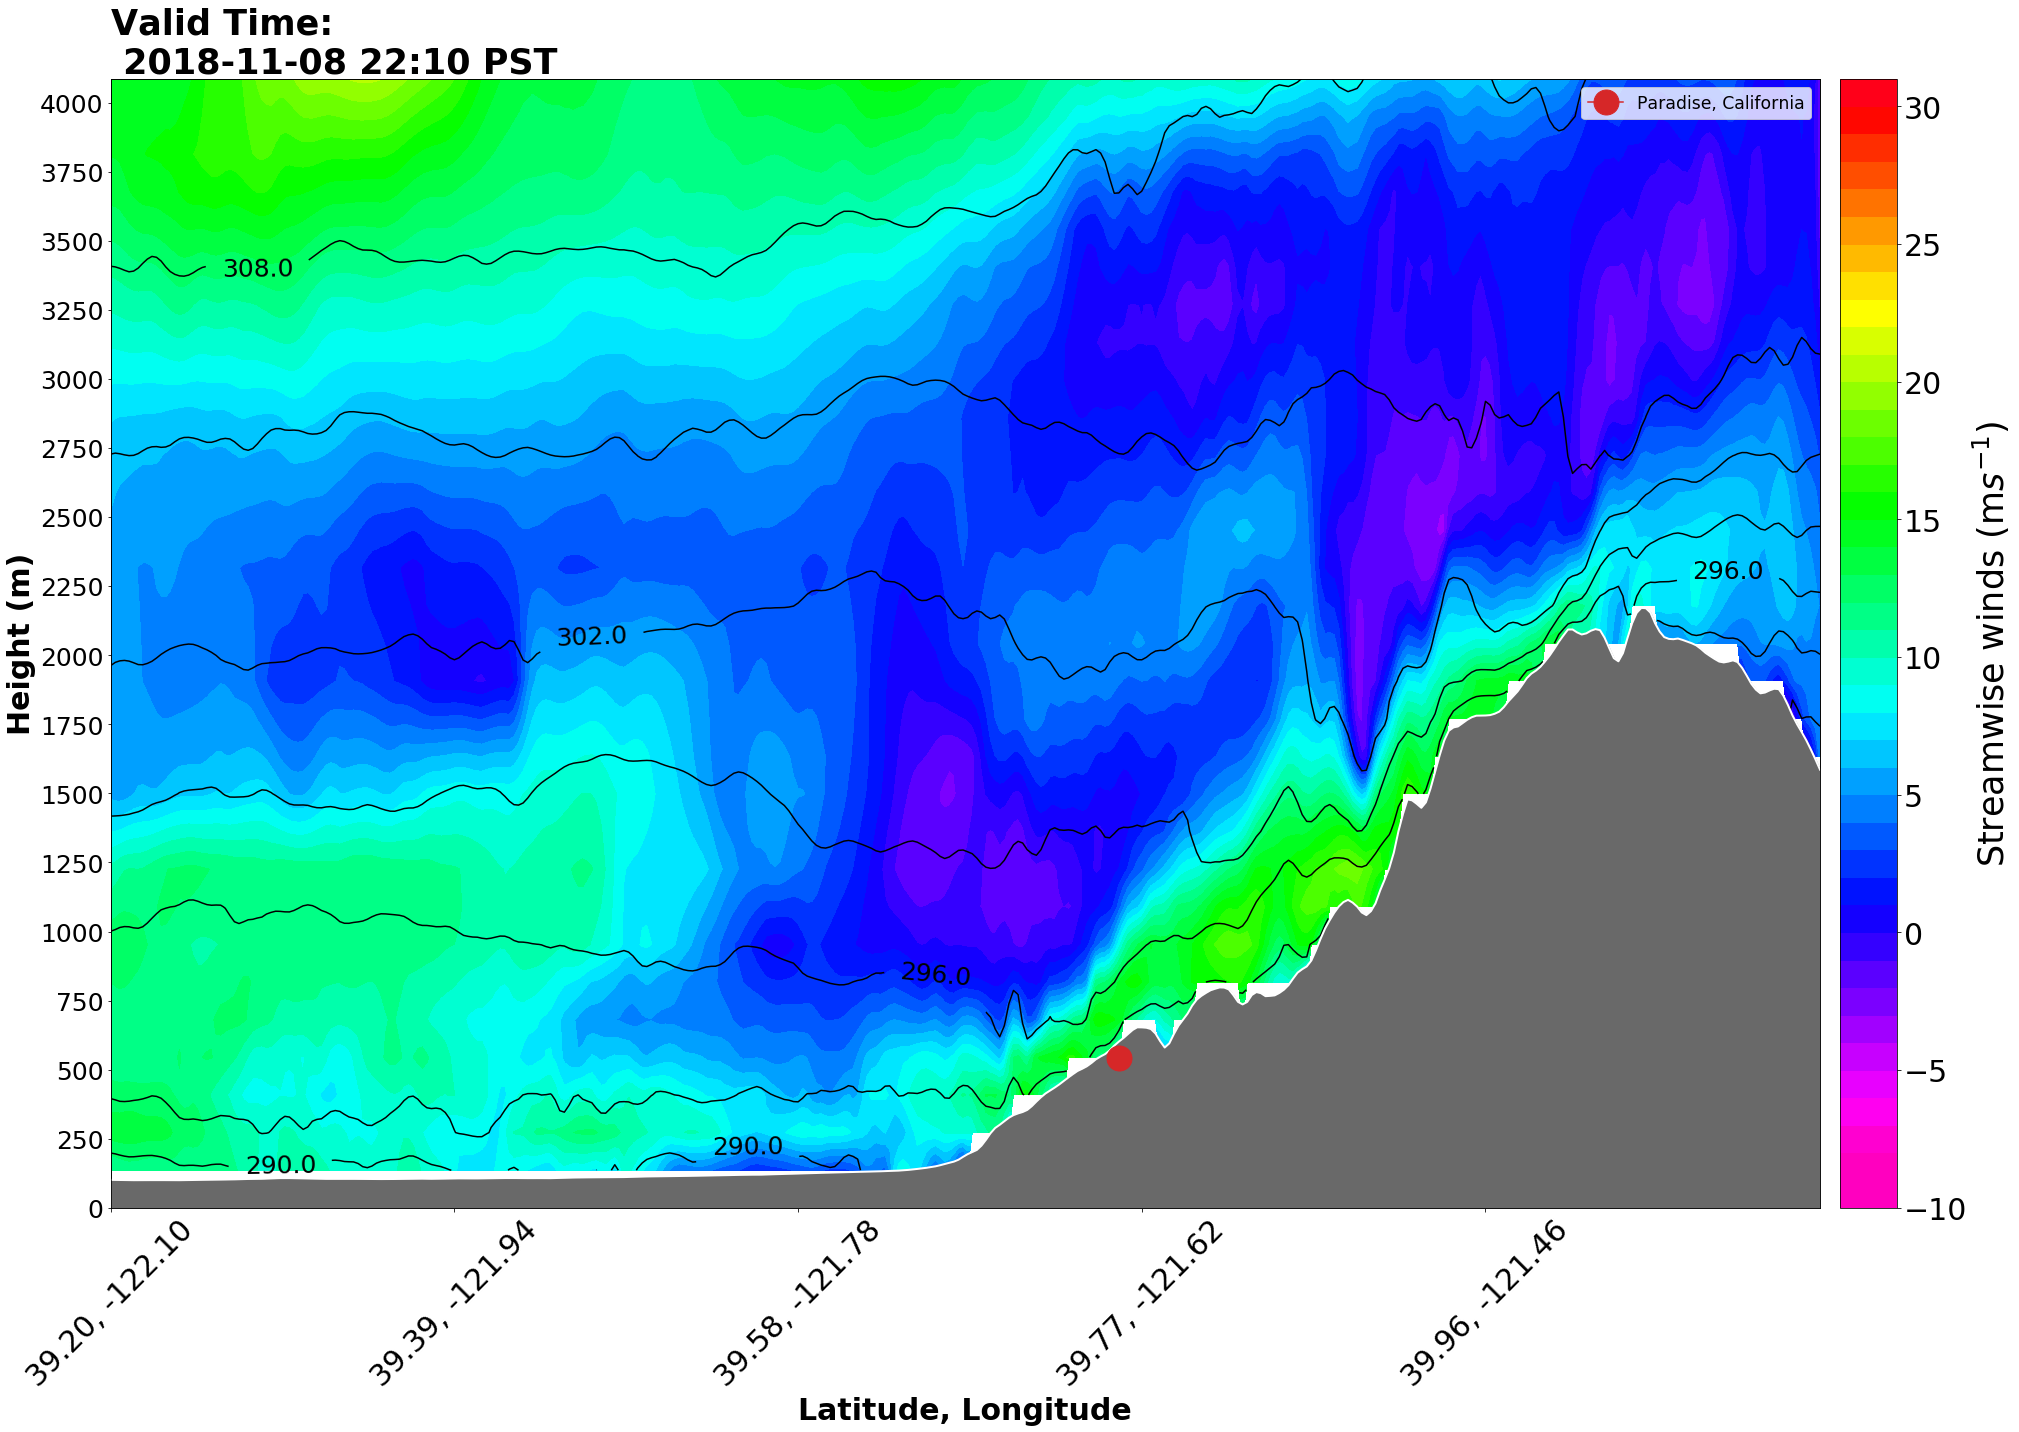

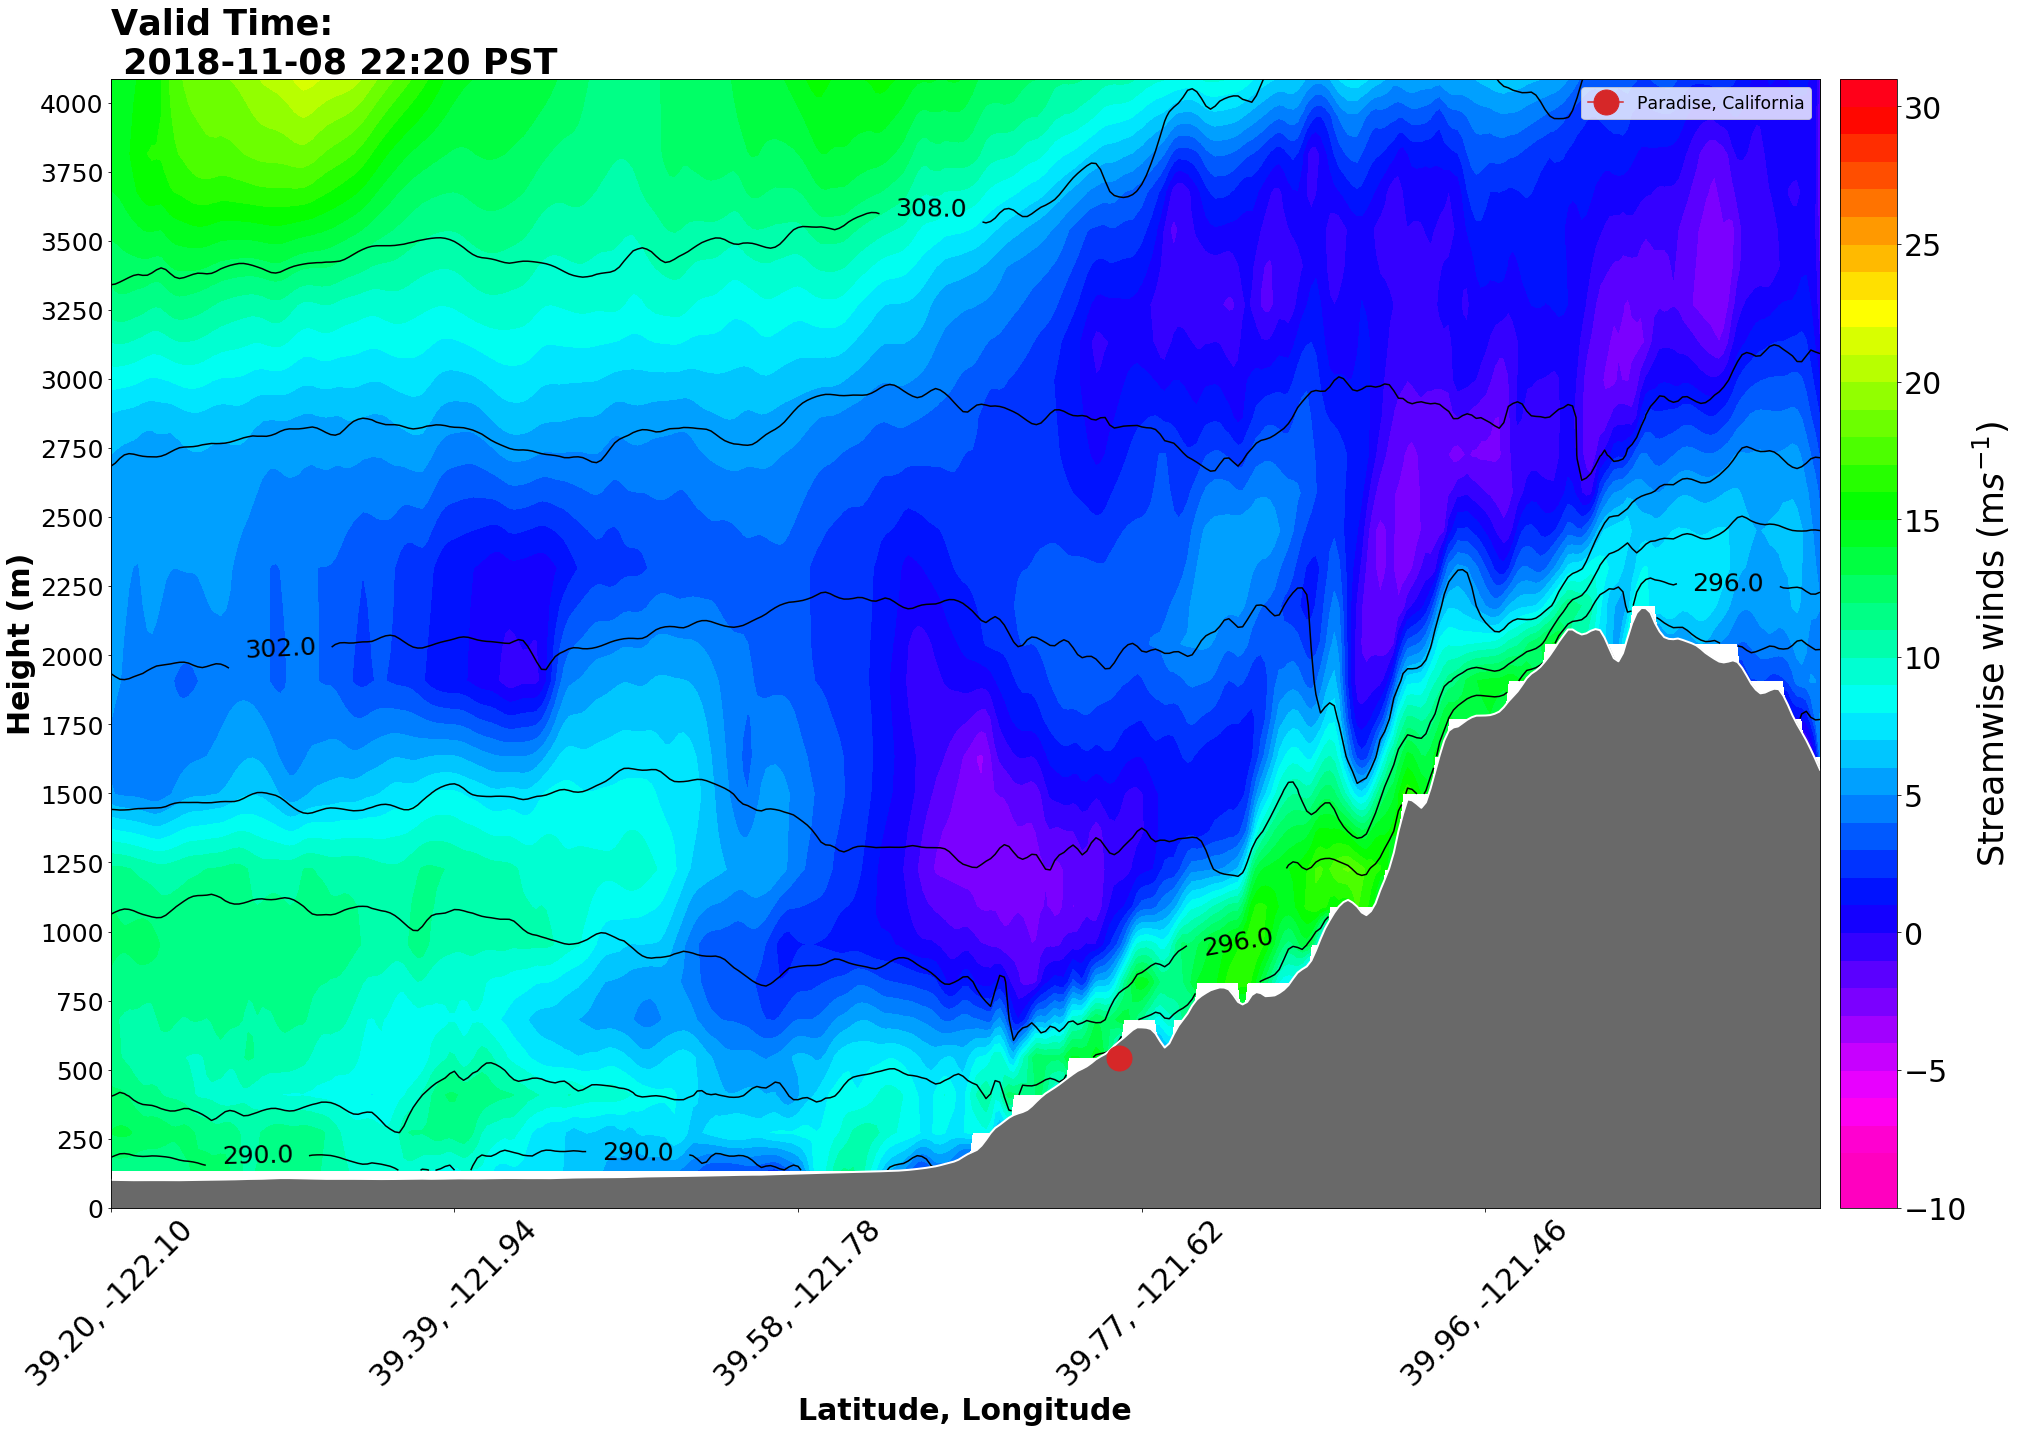

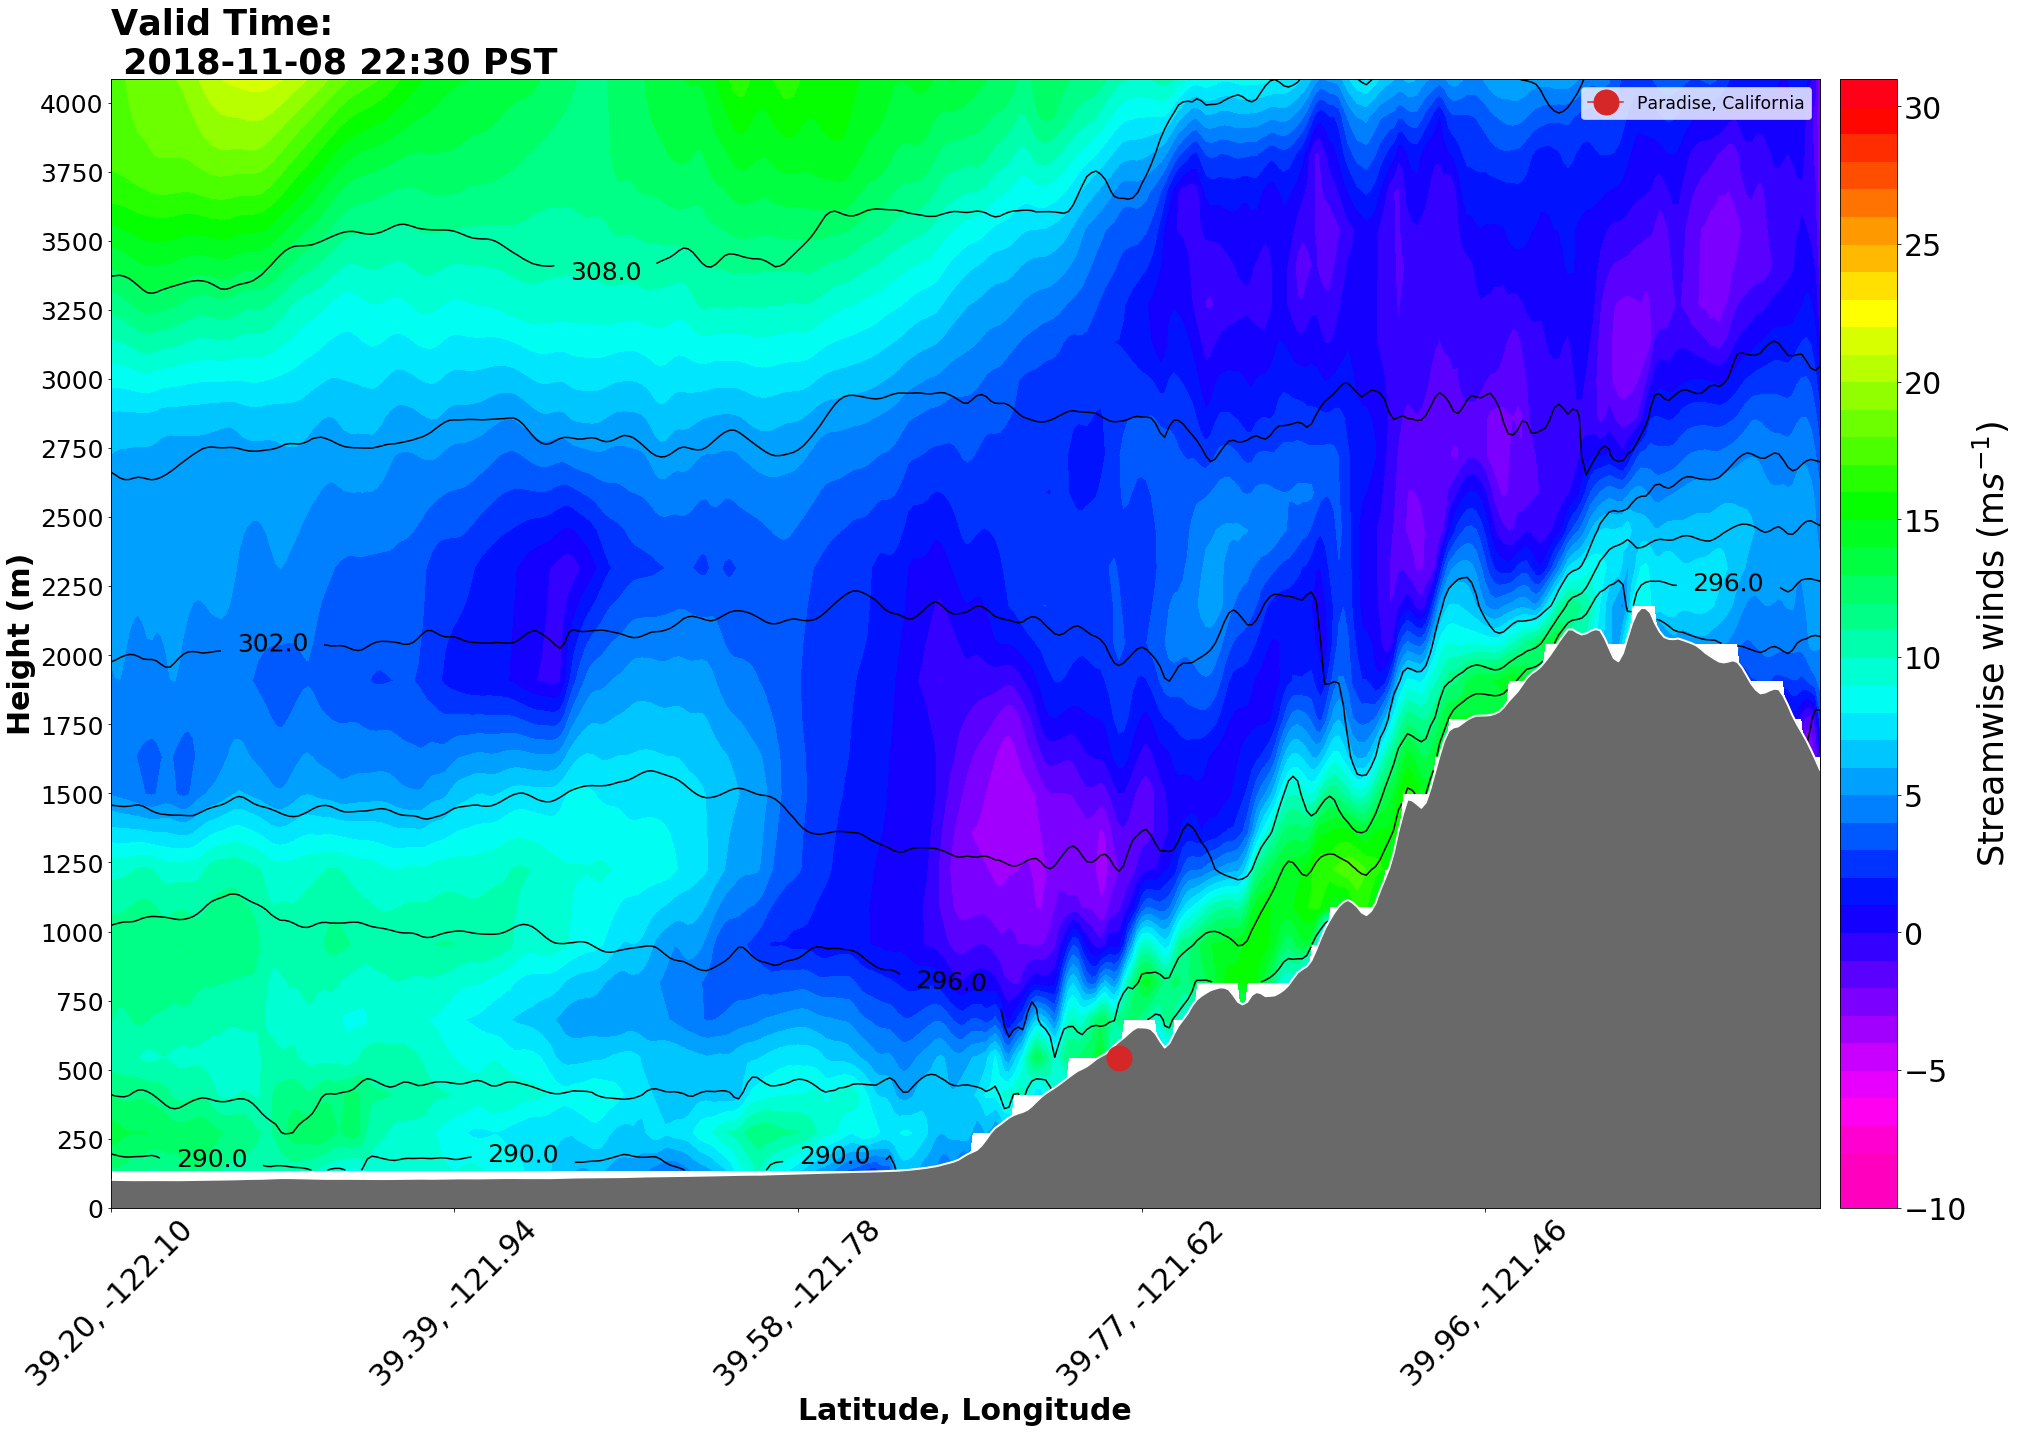

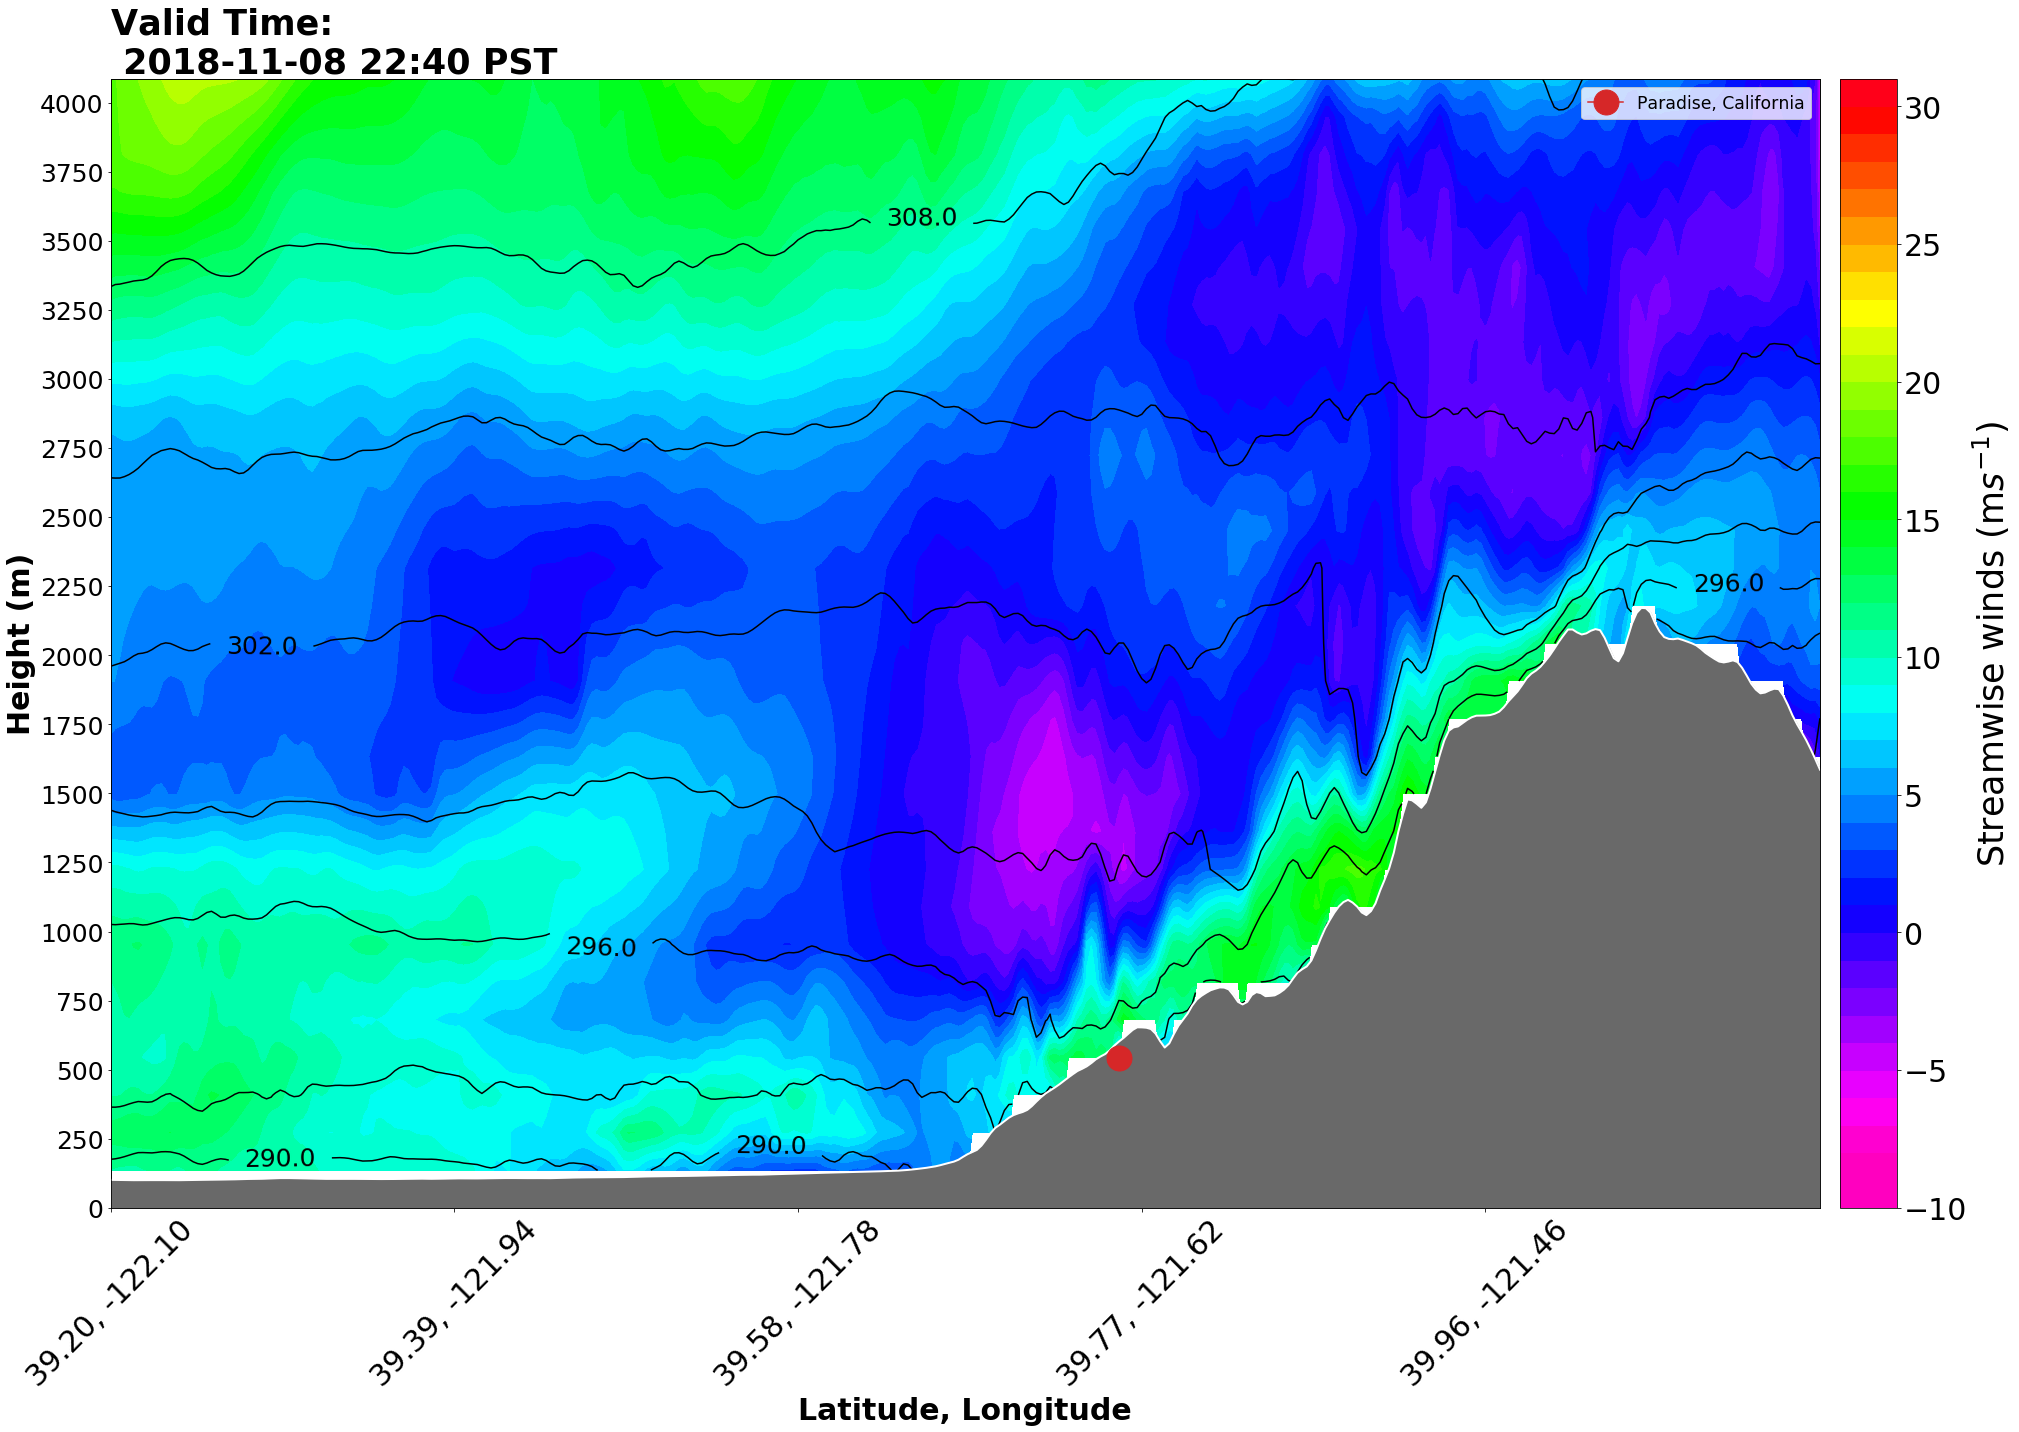

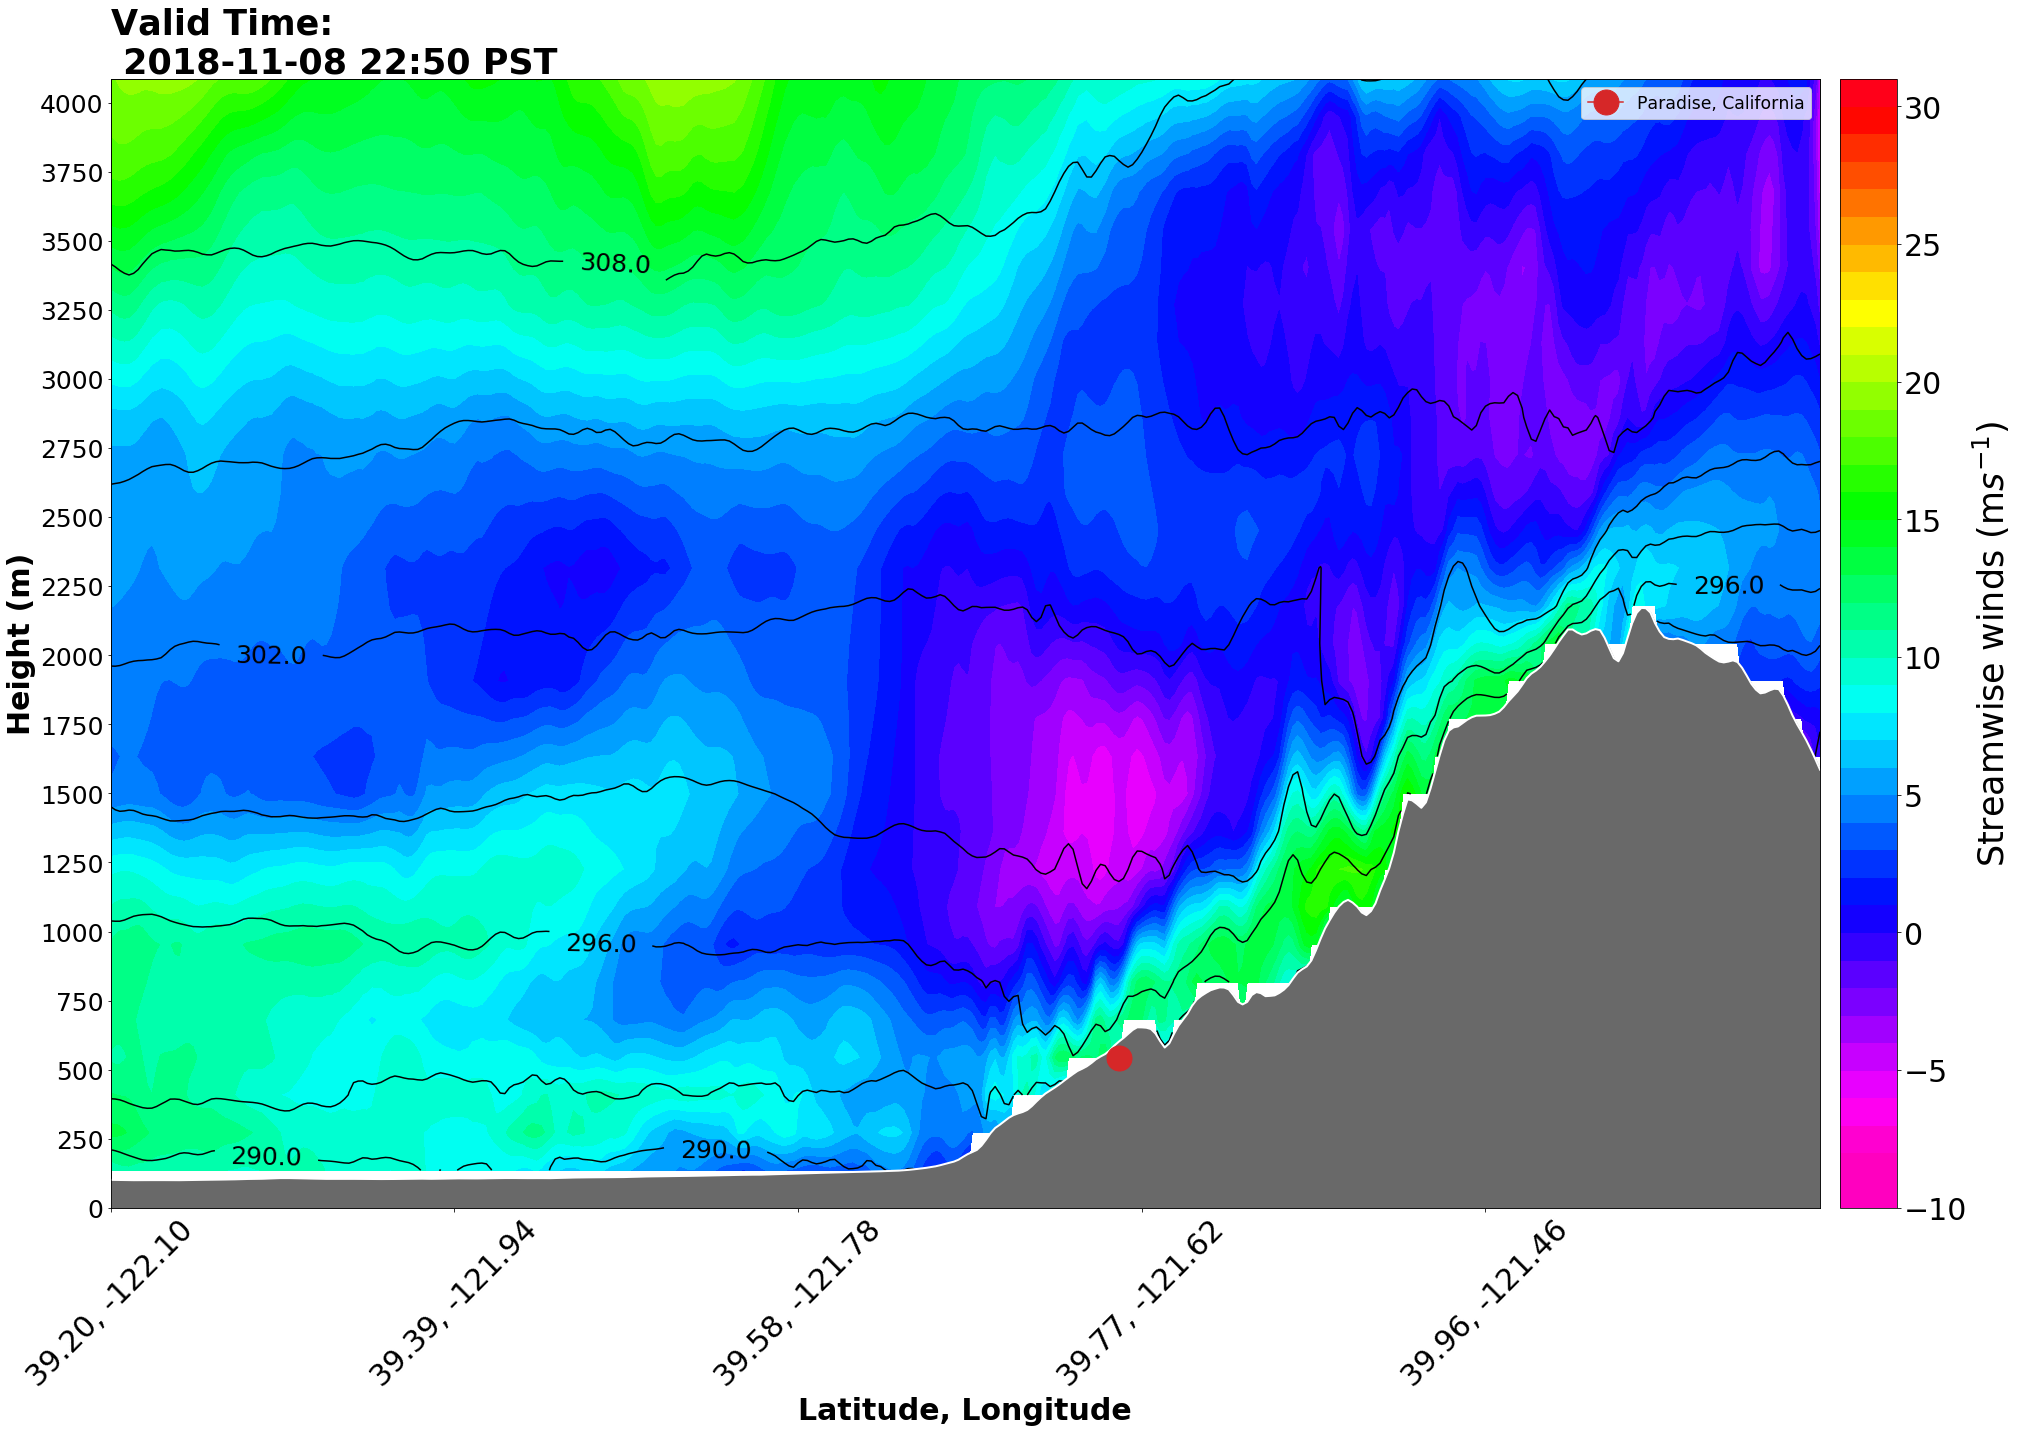

In [3]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import scipy.ndimage as ndimage
from wrf import(getvar,interplevel, to_np, latlon_coords, interpline, get_cartopy, cartopy_xlim, cartopy_ylim,ALL_TIMES, vertcross, smooth2d, CoordPair, GeoBounds)
from metpy.plots import USCOUNTIES
import metpy.calc as mpcalc
from metpy.units import units
import pandas as pd

############################################
#mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']
############################################

ds = Dataset('wrfout_d03_2018-11-09_06:00:00')
time = getvar(ds, "times",timeidx=ALL_TIMES)
### Reading in local road shapefiles to be used with the "base map", the roads help to give some spatial scale and awarenes in my opinion
reader = shpreader.Reader('/export/home/mbrewer/wrf_out/shapefiles/tl_2018_06_prisecroads.shp')
roads = list(reader.geometries())                                                                     ## Most major California roadways
roads = cfeature.ShapelyFeature(roads, crs.PlateCarree())

reader = shpreader.Reader('/export/home/mbrewer/wrf_out/shapefiles/tl_2018_06007_roads.shp')
s_roads = list(reader.geometries())                                                                  ### All roads in Butte county.... kinda messy
s_roads = cfeature.ShapelyFeature(s_roads, crs.PlateCarree())

# Function used to create the "base map for all of the plots"
def plot_background(ax):

    ax.coastlines(resolution='10m', linewidth=2, color = 'black', zorder = 4)
    political_boundaries = NaturalEarthFeature(category='cultural',
                                   name='admin_0_boundary_lines_land',
                                   scale='10m', facecolor='none')
    states = NaturalEarthFeature(category='cultural',
                                   name='admin_1_states_provinces_lines',
                                   scale='50m', facecolor='none')

    ax.add_feature(political_boundaries, linestyle='-', edgecolor='black', zorder =4)
    ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2, zorder =4)
    ax.add_feature(USCOUNTIES.with_scale('500k'), edgecolor='black', linewidth=1, zorder = 1) #### Using Metpy's county shapefiles due to hi-resolution and they also help with spartial awareness
    ax.add_feature(roads, facecolor='none', edgecolor='dimgrey', zorder = 1, linewidth = 1) 
    return ax

##### Funtiction used to calculate the Streamwise component of a wind from a specified angle
def streamwise(Ua,Va, deg = 30):
    
    """ Function used to calculated the streamwise component of the wind base off https://www.eol.ucar.edu/content/wind-direction-quick-reference
     deg
    """
    Ugeo=-1*np.sin(np.deg2rad(deg))
    Vgeo=-1*np.cos(np.deg2rad(deg))
    D=np.arctan2(Vgeo,Ugeo)
    Us=Ua*np.cos(D)+Va*np.sin(D)
    Vs=-Ua*np.sin(D)+Va*np.cos(D)
    return Us,Vs  


def t_ind(Time):
    
    """ Time = Local time
    input time sting in Y-m-d H:M:S format """
    ds_time = pd.to_datetime(time.data).tz_localize('UTC').tz_convert('US/Pacific')
    T = pd.to_datetime(Time, format = '%Y-%m-%d %H:%M:%S').tz_localize('UTC').tz_convert('US/Pacific')
    T_ind = np.where(ds_time == T)
    t = int(T_ind[0])
    ts = str(T)[:-9]
    return t,ts

def VPD(T, RH):
    
    """ T2 can be either kelvin or celcius, the saturation vapor pressure equation requires celcius but there is a fix in the fucntion 
    Saturation Vapor Pressure ased of Bolton 1980:6.112 e^\frac{17.67T}{T + 243.5}
    Vapor Pressure is based of RH = (e/es)*100 ---> e = (RH/100) * es"""
    
    if T.max() > 200:
        T = T -273.15
    svp = 6.112 * np.exp((17.67*T)/(T+243.5))
    vp = (RH/100)*svp
    VPD = svp-vp
    return VPD
theta =  getvar(ds, "th",timeidx=ALL_TIMES,)
ter = getvar(ds, 'ter')
z=getvar(ds,'z',timeidx=ALL_TIMES)
z_levels=z[0,:30,0,0] #this limits vertical extent of plot to first 30 levels
U,V=getvar(ds,'uvmet',timeidx = ALL_TIMES) #U and V through the height of the atmosphere

U_s,V_s = streamwise(U,V) ## Calculating streamwise wind @30

t_list = ['2018-11-09 06:00:00', '2018-11-09 06:10:00','2018-11-09 06:20:00','2018-11-09 06:30:00','2018-11-09 06:40:00','2018-11-09 06:50:00']
for t in t_list:
    t, ts = t_ind(t)
    skip = 10
    cf_var = U_s
    con_var  = theta

    # Set the start point and end point for the cross section
    start_point = CoordPair(lat=39.2, lon=-122.1)
    end_point = CoordPair(lat=40.15, lon=-121.3)
    ter_line = interpline(ter, wrfin=ds, start_point=start_point,end_point=end_point, latlon=True, meta=False)

    theta_cross = vertcross(con_var[t], z[t],wrfin=ds,  start_point=start_point,
                        end_point=end_point, latlon=True, meta=True, autolevels = 150)
    td_cross = vertcross(cf_var[t], z[t], wrfin=ds, start_point=start_point,
                           end_point=end_point, latlon=True, meta=True,autolevels = 150)
    stream_cross = vertcross(U_s[t], z[t], wrfin=ds, start_point=start_point,
                           end_point=end_point, latlon=True, meta=True,autolevels = 150)
    fig = plt.figure(figsize=(30,20))
    ax = fig.add_subplot(1,1,1)
     #Make the contour plot for wind speed
    clevs = np.arange(-10,32,1)
    w_contours = ax.contourf(to_np(stream_cross),levels = clevs, cmap="gist_rainbow_r", vmin = -8)
    # Add the color bar
    cb = fig.colorbar(w_contours, ax=ax, pad = 0.01)
    cb.ax.tick_params(labelsize=30)
    cb.set_label('Streamwise winds (m$s^{-1}$)', fontsize = 35 )

    # Make the contour plot for dbz
    lev = np.arange(200, 350, 3)
    theta_contours = ax.contour(to_np(theta_cross), levels = lev, colors = 'k')
    ax.clabel(theta_contours,theta_contours.levels[::2], inline =1, colors='black',fontsize = 25, fmt = '%.1f')

    # Set the x-ticks to use latitude and longitude labels
    # Set the x-ticks to use latitude and longitude labels
    coord_pairs = to_np(theta_cross.coords["xy_loc"])
    x_ticks = np.arange(coord_pairs.shape[0])
    x_labels = [pair.latlon_str(fmt='{:.2f}, {:.2f}') for pair in to_np(coord_pairs)]

    # Set the desired number of x ticks below
    num_ticks = 5
    thin = int((len(x_ticks) / num_ticks) + .5)
    ax.set_xticks(x_ticks[::thin])
    ax.set_xticklabels(x_labels[::thin], rotation=45, fontsize=30)

    # Set the y-ticks to be height
    vert_vals = to_np(theta_cross.coords["vertical"])
    vert_vals = np.round(vert_vals, decimals= 0)
    v_ticks = np.arange(vert_vals.shape[0])
    ax.set_yticks([])
    #ax.set_yticklabels(np.arange(0,4250,250), fontsize=30)
    plt.ylim(0, 30)
    ###
    ax.set_xlabel("Latitude, Longitude", fontsize=30, fontweight = 'bold')


    # Add a title
    #plt.title('WRF %0.1f m'%(ds.DX), loc='left', fontweight='bold', fontsize = 35)
    #plt.title('Color Fill: %s\n Contours: %s'%(cf_var.description.title(),con_var.description.title()), loc='center', fontweight='bold', fontsize = 30)
    plt.title('Valid Time:\n %s PST' % (ts), loc='left', fontweight='bold', fontsize = 35)


    ##### Plot elevation under the x-sec and fill under
    ax1=ax.twinx()
    offset=86 #lift terrain to cover white terrain blocks
    x_length=np.arange(len(ter_line))
    ax1.plot(to_np(ter_line)+offset,color='white',linewidth=2.0) #terrain outline
    ax1.fill_between(x_length,to_np(ter_line)+offset,vert_vals[0],color='dimgrey') #terrain fill
    ticks = ax1.set_ylim(0,4086) #lower or raise your terrain here to get it perfect
    plt.xlim(0,len(ter_line)-1)
    ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base = 250))
    ax1.yaxis.tick_left()
    ax1.set_yticklabels(np.arange(-250,4250,250),fontsize=25)
    ax1.plot(220, 542, markersize = 50, marker = '.', label = 'Paradise, California', color = 'tab:red',zorder = 5)
    ax1.legend(fontsize = 'xx-large')
    ax1.yaxis.set_label_position("left")
    ax1.set_ylabel("Height (m)", fontsize=30, fontweight = 'bold')

    plt.tight_layout()

    plt.savefig('/export/home/mbrewer/wrf_out/%s.png'% ('xsec_windspeed_theta'+ str(ds.DX) + '_' + ts),dpi = 300, bbox_inches = 'tight')
    plt.show()